In [1]:
import re
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib import cm
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = "../../data/cleaned_data.xlsx"

mission_df = pd.read_excel(data, sheet_name="missions")
mission_df['year'] = mission_df['Date'].apply(lambda x: re.search(r"\d{4}", x).group(0))
mission_df = mission_df.drop(['Date', 'Location'], axis="columns")
mission_df.head()

,Company Name,Status Rocket,Cost,Status Mission,Country,Vehicle,Mission,year
0,SpaceX,Active,50.00,Success,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky,2020
1,CASC,Active,29.75,Success,China,Long March 2D,Gaofen-9 04 & Q-SAT,2020
2,SpaceX,Active,NaN,Success,USA,Starship Prototype,150 Meter Hop,2020
3,Roscosmos,Active,65.00,Success,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103,2020
4,ULA,Active,145.00,Success,USA,Atlas V 541,Perseverance,2020


In [3]:
df = mission_df[['Company Name', 'Status Rocket', 'Cost', 'Status Mission', 'Country', 'Vehicle', 'year']]
df.head()

,Company Name,Status Rocket,Cost,Status Mission,Country,Vehicle,year
0,SpaceX,Active,50.00,Success,USA,Falcon 9 Block 5,2020
1,CASC,Active,29.75,Success,China,Long March 2D,2020
2,SpaceX,Active,NaN,Success,USA,Starship Prototype,2020
3,Roscosmos,Active,65.00,Success,Kazakhstan,Proton-M/Briz-M,2020
4,ULA,Active,145.00,Success,USA,Atlas V 541,2020


### Seperate Datasets which either have null values or don't

In [4]:
df_nonnull_cost = df.loc[~df['Cost'].isna()].reset_index(drop=True)
df_null_cost = df.loc[df['Cost'].isna()].reset_index(drop=True)

In [5]:
cols=['Country', 'Company Name', 'Status Rocket', 'Status Mission', 'Vehicle']
from category_encoders import TargetEncoder
encoder=TargetEncoder(cols=cols) 
cat_encoded = encoder.fit_transform(df_nonnull_cost[cols],df_nonnull_cost['Cost'])

In [6]:
cols=['Country', 'Company Name', 'Status Rocket', 'Status Mission', 'Vehicle']
df_nonnull_cost = df_nonnull_cost.drop(labels=cols, axis="columns")
df_nonnull_cost = pd.concat([df_nonnull_cost, cat_encoded], axis="columns")
df_nonnull_cost.head()

,Cost,year,Country,Company Name,Status Rocket,Status Mission,Vehicle
0,50.00,2020,216.000657,54.989899,81.479625,157.551143,50.000000
1,29.75,2020,40.273797,40.128228,81.479625,157.551143,29.750000
2,65.00,2020,264.141304,51.630435,81.479625,157.551143,65.000546
3,145.00,2020,216.000657,151.000000,81.479625,157.551143,145.021740
4,64.68,2020,40.273797,40.128228,81.479625,157.551143,64.680000


In [7]:
df_nonnull_cost.corr()

,Cost,Country,Company Name,Status Rocket,Status Mission,Vehicle
Cost,1.000000,0.287901,0.943372,0.312299,0.059597,0.641270
Country,0.287901,1.000000,0.345323,0.315368,0.007055,0.374317
Company Name,0.943372,0.345323,1.000000,0.370891,0.057343,0.630315
Status Rocket,0.312299,0.315368,0.370891,1.000000,-0.039267,0.414510
Status Mission,0.059597,0.007055,0.057343,-0.039267,1.000000,0.059899
Vehicle,0.641270,0.374317,0.630315,0.414510,0.059899,1.000000


In [8]:
target = "Cost"
cols = [x for x in df_nonnull_cost.columns.values if x != target]
X = df_nonnull_cost[cols]
y = df_nonnull_cost[target]

In [9]:
X.shape, y.shape

((964, 6), (964,))

In [10]:
y.describe()

count     964.000000
mean      153.792199
std       288.450732
min         5.300000
25%        40.000000
50%        62.000000
75%       164.000000
max      5000.000000
Name: Cost, dtype: float64

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [20]:
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_reg = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_reg.score(X_test, y_test)

0.9851564672058424

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error
# r2_score(y_test, y_pred)
mean_absolute_error(y_test, y_pred)

1.6058273793103894

In [22]:
error_df = pd.concat([
    pd.Series(X_test.mean(axis=1).values, name="X_test"),
    pd.Series(y_test.values, name="y_test"),
    pd.Series(y_pred, name="y_pred")
], axis=1)
error_df['error'] = abs(error_df['y_pred'] - error_df['y_test'])
error_df.head()

,X_test,y_test,y_pred,error
0,76.822559,64.68,64.6800,2.557954e-13
1,320.278786,450.00,450.0000,0.000000e+00
2,151.619678,59.00,59.0000,0.000000e+00
3,320.278786,450.00,450.0000,0.000000e+00
4,122.777211,7.00,6.9525,4.750000e-02


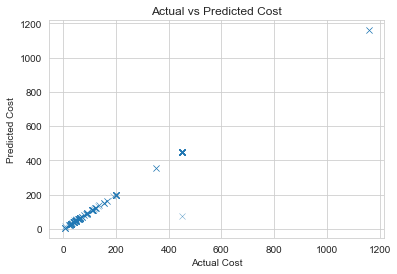

In [28]:
sns.scatterplot(x=y_test, y=y_pred, marker="x", alpha=0.7).set(title="Actual vs Predicted Cost", xlabel="Actual Cost", ylabel="Predicted Cost")
plt.show()

In [367]:
error_df[['y_test', 'y_pred']].describe()

,y_test,y_pred
count,241.000000,241.000000
mean,149.335104,149.412924
std,174.946159,174.932132
min,5.300000,5.300000
25%,40.000000,40.018000
50%,64.680000,64.680000
75%,200.000000,200.000000
max,1160.000000,1160.000000


In [368]:
mape = 100 * (error_df['error'] / error_df['y_test'])
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 98.88 %.
